<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA4_MultinomialDirichlet_learned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling with Multinomial - Dirichlet Model

In this notebook, we see an example of Topic Modelling using the Multinomial - Dirichlet model. We recall that this model is defined as follows:

Let $X_i$ be the word $i$ in the document we are analyzing, for $i = 1, \dots, N$. The law for $X_i$ is the following:
$$
    \mathbb{P}(X_i = j) = \lambda_j \qquad j = 1, \dots, \lvert V \rvert,
$$
where $\lvert V \rvert$ is the size of the vocabulary and $j$ is a label for the word.

Of course, in a document words will have repetitions. Since the order in which a word appear is not important, we can define $Y_j$ being the frequency of word $j$ in the document.

## Bayesian Model

\begin{align*}
    \left( y_1, \dots, y_{n} \right) \mid \boldsymbol{\lambda} &\stackrel{\tiny\mbox{iid}}{\sim} \operatorname{Multinomial}\left(\boldsymbol{\lambda}\right); \\
    \boldsymbol{\lambda} &\sim \operatorname{Dirichlet}\left(\boldsymbol{\alpha}\right).
\end{align*}

We recall that:

\begin{align*}
    f\left(\boldsymbol{y} \mid \boldsymbol{\lambda}\right) &= \frac{n!}{y_1! \dots y_{\lvert V \rvert}!} \prod_{j=1}^{\lvert V \rvert} \lambda_{j}^{y_j}, &\qquad\pi\left(\boldsymbol{\lambda}\right) &= \frac{1}{B\left(\boldsymbol{\alpha}\right)} \prod_{j = 1}^{\lvert V \rvert} \lambda_{j}^{\alpha_j - 1},
\end{align*}

with $y_j \in \mathbb{N} \cup \{0\}$ for all $j$, $\sum_{j = 1}^{\lvert V \rvert} y_j = n$, $\alpha_j \geq 0$ for all $j$ and $\sum_{j=1}^{\lvert V \rvert}\alpha_j = 1$.

In [1]:
!pip install nltk

In [2]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import requests

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

# Import required functions
from collections import Counter

from nltk import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Uncomment those lines if it is the first time you are running this notebook
from nltk import download
download('punkt_tab')
download('stopwords') #Stop words like "the" and "is" appear frequently, but not important

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In the following chunks we simply get some data from the Wikipedia page of Roberto Baggio and build up our dataset.

In [4]:
raw = requests.get(
    "https://en.wikipedia.org/w/api.php?action=query&format=json&titles=Roberto_Baggio&prop=extracts&explaintext")
# Fetches data using Wikipedia's API.
text = raw.json()["query"]["pages"]["25624"]["extract"]
# perform a query on wikipedia
# retrieve(return back) the data in JSON format(easy to deal with)
# 25624 is the page ID of the page title "roberto baggio"
# return only plain text, excluding HTML

In [5]:
nltk.download('punkt')
tokens = word_tokenize(text) #Tokenizing(breaking) sentences into words
tokens = [word.lower() for word in tokens if word.isalpha()]
# converts all words to lowercase-word.lower()
# word.isalpha- filters out non alphabetic tokens(e.g punctuations, numbers)

stopw = stopwords.words("english") # load the list of english stop word from NLTK

tokens = list(filter(lambda x: x not in stopw, tokens)) # filter out tokens which are present in the stop words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let us print the 10 most probable words...

In [6]:
counts = Counter(tokens) # counting the frequency in the tokens
counts.most_common(10)

[('baggio', 373),
 ('world', 101),
 ('cup', 94),
 ('italy', 94),
 ('goals', 85),
 ('serie', 85),
 ('scored', 79),
 ('goal', 78),
 ('also', 74),
 ('player', 69)]

... and **always** remember to plot your data!

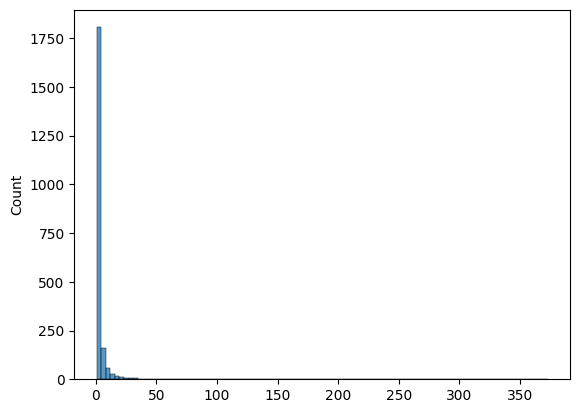

In [7]:
import seaborn as sns

words_and_counts = counts.most_common()
sns.histplot([x[1] for x in words_and_counts], bins=100)
plt.show()
# insight: most words occur very few times(1 or 2),
# only a few words occur very frequently (baggio over 300)
# the distribution is right-skewed, which is common in natural language text data

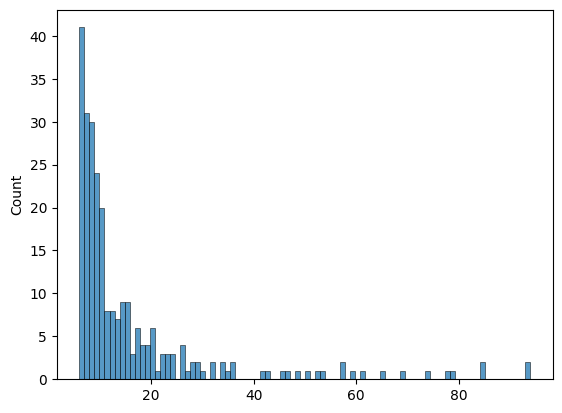

In [8]:
words_and_counts = [
    (w, c) for (w, c) in words_and_counts if c > 5 and c < 100]
sns.histplot([x[1] for x in words_and_counts], bins=90)
plt.show()
# filter the list above to include only words whose frequency 5 < c < 100

In [9]:
len(words_and_counts) # the total number of the filtered data

258

## Bayesian analysis

### Posterior Distribution

Simple computation leads to:

$$ \pi\left(\boldsymbol{\lambda} \mid \boldsymbol{y} \right) \sim \operatorname{Dirichlet}\left(\boldsymbol{\alpha} + \boldsymbol{y}\right)$$

In [10]:
vocabulary = [x[0] for x in words_and_counts] # extracts the list of words, first element of each tuple in the matrix
len_v = len(vocabulary) # count the total number of unique words
n = np.array([x[1] for x in words_and_counts]) # convert the counts- second element unto numpy array

# prior
alpha = np.ones(len_v) # equal probability for all words (1,...,1)

### Predictive Distribution

compute

$$ p(x_{n+1} = j \mid x_1, \ldots, x_n) = \frac{\alpha_j + n_j}{\sum \alpha_h + \sum n_h}$$

for every $j = 1, \dots, \lvert V \rvert$

In [11]:
pred_dist = np.zeros(len_v) # an array to store the predictive probability

den = np.sum(alpha) + np.sum(n) # calculate the denominator

for j in range(len_v):
    pred_dist[j] = alpha[j] + n[j]

pred_dist /= den

# the result us the predictive probability for each word

In [12]:
# Check that it sums to 1, it is ok
print(np.sum(pred_dist))

# prediction, we can get the prediction probability(postieor probability) for the word which we already observed
# in the same time we can also get the prediction for new words we did not observed, and prob is not zero

1.0


In [13]:
# Get the 5 most probable words ...
ind = np.argpartition(pred_dist, -5)[-5:][::-1]
# partitions the array such that the top 5 largest elements are moved to the end of the array, order of them is not guaranteed
# [-5:]extracts the indices of the top 5 elements
# [::-1] reverse the order of thre indices, so the most prob word comes first

for i in ind:
    print("word: {0}, prob: {1}".format(vocabulary[i], pred_dist[i]))

word: cup, prob: 0.021532184950135994
word: italy, prob: 0.021532184950135994
word: serie, prob: 0.019492293744333637
word: goals, prob: 0.019492293744333637
word: scored, prob: 0.01813236627379873


In [14]:
# ... and the 5 leas probable words
ind = np.argpartition(pred_dist, 5)[:5]
for i in ind:
    print("word: {0}, prob: {1}".format(vocabulary[i], pred_dist[i]))

word: ac, prob: 0.001586582048957389
word: another, prob: 0.001586582048957389
word: particular, prob: 0.001586582048957389
word: zico, prob: 0.001586582048957389
word: eight, prob: 0.001586582048957389


### Test randomness

$$
 H_0: \theta = \left(\frac{1}{|V|} \cdots \frac{1}{|V|}\right) \quad vs. \quad H_0: \theta \neq \left(\frac{1}{|V|} \cdots \frac{1}{|V|}\right)
$$

Let $\theta_0 = \left(\frac{1}{|V|} \cdots \frac{1}{|V|}\right)$, then

$$
BF_{01} = \frac{L(d | \theta_0)}{\int_{S^{|V|}} L(d | \theta) \pi(\theta) \mathrm{d}\theta}
$$

In [15]:
# H0: all probabilities are equal, uniform
# H1: the probabilities are not equal
# we use bayes factor to compare the 2 hypotheses
# when we use diricht distribution as a prior which includes gamma function, leads to denominator close to 0
# and we return nan

In [16]:
from scipy.special import gamma

def multi_beta_fn(alpha):
    return np.prod(gamma(alpha)) / gamma(np.sum(alpha))

In [17]:
theta0 = np.ones(len_v) / len_v

num = np.prod(theta0 ** n)
den = multi_beta_fn(alpha + n) / multi_beta_fn(alpha)

print(np.log10(num/den))

nan


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-16-bc73e37e7326>:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.prod(gamma(alpha)) / gamma(np.sum(alpha))


In [18]:
print(num)
print(den)

0.0
nan


Python warns us that overflow occurred. This always happens when we try to compute products of terms involving factorials.

*What to do?* **Move computations to log scale!** In this case:

In [19]:
from scipy.special import loggamma

def log10gamma(x):
    return loggamma(x) / np.log(10.0)

def log_multi_beta_fn(alpha):
    return np.sum(log10gamma(alpha)) - log10gamma(np.sum(alpha))

log_num = np.sum(n * np.log10(theta0))
log_den = log_multi_beta_fn(alpha + n) - log_multi_beta_fn(alpha)

print(log_num - log_den)

-435.5599428922196
